In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import AutoModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
import torch
from spacy.lang.en import English
dvu.set_style()
import sys
sys.path.append('..')
import pandas as pd
from functools import partial
from embgam import analyze_helper
from embgam import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import embgam

# Calculate interpolation stuff

In [ ]:
dsets = ['financial_phrasebank', 'rotten_tomatoes', 'sst2', 'emotion']
out = defaultdict(list)
for dset in tqdm(dsets):
    # get data
    dataset, dataset_key_text = embgam.data.process_data_and_args(dset)
    dval = dataset['validation']

    # load embgam model #####################################################
    embgam_checkpoints = {
        # 'tweet_eval': 'results/best___ngram=2_sub=-1_philschmid-BERT-tweet-eval-emotion__last_hidden_state_mean__1-all.pkl',
        'rotten_tomatoes': 'results/best___ngram=5_sub=-1_textattack-bert-base-uncased-rotten_tomatoes__2-all.pkl',
        'emotion': 'results/best___ngram=6_sub=-1_nateraw-bert-base-uncased-emotion__2-all.pkl',
        'financial_phrasebank': 'results/best___ngram=7_sub=-1_ahmedrachid-FinancialBERT-Sentiment-Analysis__3-all.pkl',
        'sst2': 'results/best___ngram=7_sub=-1_textattack-bert-base-uncased-SST-2__3-all.pkl',
    }
    row = pd.Series(
        pkl.load(open(oj(config.repo_dir, embgam_checkpoints[dset]), 'rb')))
    model = AutoModel.from_pretrained(row.checkpoint).to('cuda')
    logistic = row.model
    tokenizer_ngrams = English().tokenizer  # for our word-finding
    tokenizer_embeddings = AutoTokenizer.from_pretrained(row.checkpoint)

    # get embeddings
    embed_and_sum = partial(
        embgam.embed.embed_and_sum_function,
        model=model,
        ngrams=row.ngrams,
        tokenizer_embeddings=tokenizer_embeddings,
        tokenizer_ngrams=tokenizer_ngrams,
        checkpoint=row.checkpoint,
        dataset_key_text=dataset_key_text,
        layer=row.layer,
        all_ngrams=row.all,
    )
    embedded_dataset = dval.map(embed_and_sum)  # , batched=True)
    embs = np.array(embedded_dataset['embs']).squeeze()

    # get embgam preds
    preds_proba = logistic.predict_proba(embs)
    preds = logistic.predict(embs)

    # dnn baseline #####################################################
    checkpoints = {
        'emotion': 'nateraw/bert-base-uncased-emotion',
        'rotten_tomatoes': 'textattack/bert-base-uncased-rotten_tomatoes',
        'financial_phrasebank': 'ahmedrachid/FinancialBERT-Sentiment-Analysis',
        'sst2': 'textattack/bert-base-uncased-SST-2',
    }
    dnn = pipeline('text-classification', model=checkpoints[dset], device=0)

    def score(ex):
        d = dnn(ex[dataset_key_text])
        return {'score': [out['score'] for out in d],
                'label': [out['label'] for out in d]}
    dval_dnn = dval.map(score)

    preds_proba_dnn = np.array(dval_dnn['score']).flatten()
    pred_dnn = np.array(list(map(dnn.model.config.label2id.get,
                                 np.array(dval_dnn['label']).flatten())))

    # get acc
    labs = np.array(dataset['validation']['label'])
    acc = (preds == labs).mean()
    acc_dnn = np.mean(np.array(pred_dnn) == labs)
    n = labs.size
    print('acc', acc, 'acc_dnn', acc_dnn)

    # get joint performance
    args = np.argsort(np.abs(preds_proba.max(axis=1)))[::-1]
    accs_sorted = preds[args] == labs[args]
    accs_sorted_dnn = pred_dnn[args] == labs[args]
    num_correct_cum = np.cumsum(accs_sorted)
    num_correct_cum_dnn = np.cumsum(accs_sorted_dnn)
    num_correct_combined = num_correct_cum + \
        (np.max(num_correct_cum_dnn) - num_correct_cum_dnn)

    out['dset'].append(dset)
    out['acc'].append(acc)
    out['acc_dnn'].append(acc_dnn)
    out['num_correct_cum'].append(num_correct_cum)
    out['num_correct_cum_dnn'].append(num_correct_cum_dnn)
    out['num_correct_combined'].append(num_correct_combined)
    pkl.dump(out, open(oj(config.repo_dir, 'results/acc_interpolate.pkl'), 'wb'))

# Plot results

In [2]:
out = pkl.load(open(oj(config.repo_dir, 'results/acc_interpolate.pkl'), 'rb'))

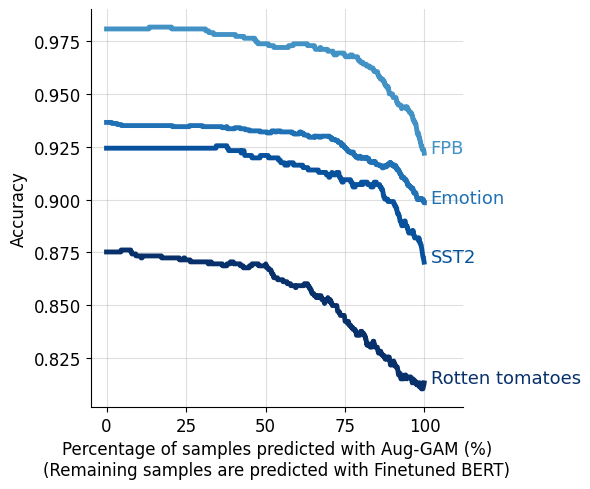

acc drops [0.007017543859649145, 0.0065666041275798115, 0.0034403669724770714, 0.0044999999999999485] 0.5381128739926494


In [26]:
dsets = out['dset']
acc_drops = []
blues = ['#4292c6','#08306b','#08519c', '#2171b5']
plt.figure(figsize=(6, 5))
for i, dset in enumerate(dsets):
    num_correct_combined = out['num_correct_combined'][i]
    n = num_correct_combined.size
    x = np.arange(n) / n * 100
    y = num_correct_combined / n
    plt.plot(x, y, lw=3.5, label=analyze_helper.DSETS_RENAME_DICT[dset].replace('Financial phrasebank', 'FPB'), color=blues[i])
    drop = out['acc_dnn'][i] - num_correct_combined[n // 2] / n
    acc_drops.append(drop)
    plt.xlabel('Percentage of samples predicted with Aug-GAM (%)\n(Remaining samples are predicted with Finetuned BERT)', fontsize='large')
    plt.ylabel('Accuracy', fontsize='large')
plt.xticks(np.arange(0, 101, 25), fontsize='large')
plt.yticks(fontsize='large')
plt.grid(alpha=0.4)    
# plt.legend(bbox_to_anchor=(1.02, 0.6), fontsize='large') #, loc='upper left')
dvu.line_legend(fontsize=13)
plt.tight_layout()
plt.savefig('acc_interpolate_gam.pdf', bbox_inches='tight')
plt.show()
print('acc drops', acc_drops, 100 * np.array(acc_drops).mean())

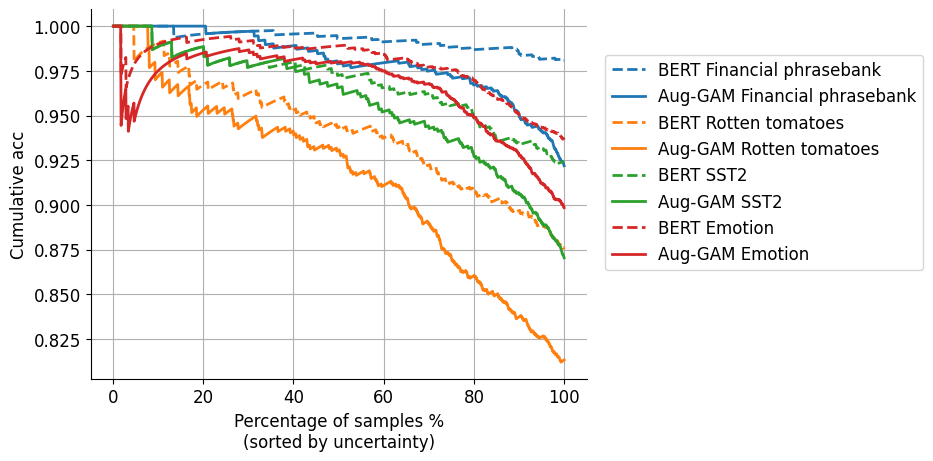

In [6]:
dsets = out['dset']
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = prop_cycle.by_key()['color']

for i, dset in enumerate(dsets):
    num_correct_cum = out['num_correct_cum'][i]
    num_correct_cum_dnn = out['num_correct_cum_dnn'][i]
    n = num_correct_cum.size
    x = np.arange(1, n + 1)
    plt.plot(x/n * 100, num_correct_cum_dnn / x, ls='--', lw=2, label='BERT ' + analyze_helper.DSETS_RENAME_DICT[dset], color=cs[i])
    plt.plot(x/n * 100, num_correct_cum / x, lw=2, label="Aug-GAM " + analyze_helper.DSETS_RENAME_DICT[dset], color=cs[i])
    plt.ylabel('Cumulative acc', fontsize='large')
    plt.xlabel('Percentage of samples %\n(sorted by uncertainty)', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.grid()    
plt.legend(bbox_to_anchor=(1.02, 0.9), fontsize='large') #, loc='upper left')
plt.savefig('acc_calibration_gam.pdf', bbox_inches='tight')
plt.show()